In [2]:
import numpy as np

# Параметры сетки
n = 16  # Количество узлов на самой тонкой сетке
h = 1 / (n + 1)

# Функция для генерации матрицы для одномерного уравнения Пуассона
def generate_poisson_matrix(n):
    A = 2 * np.eye(n) - np.eye(n, k=-1) - np.eye(n, k=1)
    return A

# Функция для решения системы методом Гаусса-Зейделя
def gauss_seidel(A, b, x, num_iterations):
    for _ in range(num_iterations):
        for i in range(len(b)):
            sum1 = np.dot(A[i, :i], x[:i])
            sum2 = np.dot(A[i, i+1:], x[i+1:])
            x[i] = (b[i] - sum1 - sum2) / A[i, i]
    return x

# Функция рестрикции (полное усреднение)
def restrict(r):
    n = len(r)
    n_coarse = n // 2
    r_coarse = np.zeros(n_coarse)
    for i in range(n_coarse):
        r_coarse[i] = 0.5 * (r[2*i] + r[2*i+1])
    return r_coarse

# Функция интерполяции (линейная интерполяция)
def interpolate(e_coarse):
    n_coarse = len(e_coarse)
    n_fine = 2 * n_coarse
    e_fine = np.zeros(n_fine)
    for i in range(n_coarse):
        e_fine[2*i] = e_coarse[i]
        if 2*i + 1 < n_fine:  # Добавляем проверку на четность
            e_fine[2*i + 1] = 0.5 * (e_coarse[i] + e_coarse[min(i + 1, n_coarse - 1)])  # Используем min() для защиты от выхода за границы массива
    return e_fine


# Функция V-цикла
def v_cycle(A, b, x, num_iterations=3):
    # Предварительное сглаживание
    x = gauss_seidel(A, b, x, num_iterations)
    
    # Вычисление невязки
    r = b - np.dot(A, x)
    
    if len(b) <= 2:
        # Прямое решение на самой грубой сетке
        e = np.linalg.solve(A, r)
    else:
        # Рестрикция невязки
        r_coarse = restrict(r)
        
        # Генерация матрицы на грубой сетке
        A_coarse = generate_poisson_matrix(len(r_coarse))
        
        # Решение на грубой сетке (рекурсивно)
        e_coarse = np.zeros(len(r_coarse))
        e_coarse = v_cycle(A_coarse, r_coarse, e_coarse, num_iterations)
        
        # Интерполяция ошибки на тонкую сетку
        e = interpolate(e_coarse)
    
    # Коррекция
    x += e
    
    # Постсглаживание
    x = gauss_seidel(A, b, x, num_iterations)
    
    return x

# Основная функция
def main():
    # Генерация матрицы и правой части
    A = generate_poisson_matrix(n)
    f = np.ones(n) * h**2  # Пример правой части
    x_initial = np.zeros(n)
    
    # Решение уравнения методом V-цикла
    x = v_cycle(A, f, x_initial)
    
    print("Решение x:")
    print(x)

if __name__ == "__main__":
    main()


IndexError: index 2 is out of bounds for axis 0 with size 2

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Load the data
df = pd.read_csv('cap1.csv')

# Convert categorical variables to numerical for analysis
df = df.replace({'Yes': 1, 'No': 0, 'Maybe': 0.5})

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Age', 'Gender', 'Occupation', 'Days_Indoors', 'Mood_Swings'])

# Define features and target variable
X = df_encoded.drop(columns=['Mental_Health_History'])
y = df_encoded['Mental_Health_History']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Print the coefficients
coefficients = dict(zip(X.columns, model.coef_))
print("Coefficients:")
for feature, coefficient in coefficients.items():
    print(feature, ":", coefficient)


Mean Squared Error: 0.16658662738222063
R-squared: -0.07816972078472806
Coefficients:
Growing_Stress : -0.007794829159675467
Quarantine_Frustrations : 0.021237375863050505
Changes_Habits : -0.019155037891704304
Weight_Change : -0.014698809050945325
Coping_Struggles : -0.023995947089900955
Work_Interest : 0.08575675516191199
Social_Weakness : -0.06735429465857881
Age_16-20 : -5566845541523.14
Age_20-25 : -5566845541523.089
Age_25-30 : -5566845541523.149
Age_30-Above : -5566845541523.144
Gender_Female : -1502558622622.5054
Gender_Male : -1502558622622.52
Occupation_Business : -15045918468298.818
Occupation_Corporate : -15045918468298.78
Occupation_Housewife : -15045918468298.799
Occupation_Others : -15045918468298.748
Occupation_Student : -15045918468298.83
Days_Indoors_1-14 days : -2316086743936.181
Days_Indoors_15-30 days : -2316086743936.0986
Days_Indoors_31-60 days : -2316086743936.176
Days_Indoors_Go out Every day : -2316086743936.1543
Days_Indoors_More than 2 months : -231608674393

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Load the data
df = pd.read_csv('cap1.csv')

# Convert categorical variables to numerical for analysis
df = df.replace({'Yes': 1, 'No': 0, 'Maybe': 0.5})

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Age', 'Gender', 'Occupation', 'Days_Indoors', 'Mood_Swings'])

# Define features and target variable
X = df_encoded.drop(columns=['Mental_Health_History'])
y = df_encoded['Mental_Health_History']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop through a range of accuracy values and find the best one
best_accuracy = 0
best_model = None
best_accuracy_value = None
for accuracy_value in np.arange(0.1, 1.1, 0.1):
    # Create and fit the linear regression model
    model = LinearRegression()
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    accuracy = scores.mean()
    print(f"Accuracy for {accuracy_value}: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_accuracy_value = accuracy_value

if best_model is not None:
    print("Best accuracy value:", best_accuracy_value)

    # Train the final model with the best accuracy value
    best_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

    # Plot actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Mental Well-being")
    plt.ylabel("Predicted Mental Well-being")
    plt.title("Actual vs. Predicted Mental Well-being")
    plt.show()
else:
    print("No suitable accuracy value found.")


Accuracy for 0.1: -0.08723835517730719
Accuracy for 0.2: -0.08723835517730719
Accuracy for 0.30000000000000004: -0.08723835517730719
Accuracy for 0.4: -0.08723835517730719
Accuracy for 0.5: -0.08723835517730719
Accuracy for 0.6: -0.08723835517730719
Accuracy for 0.7000000000000001: -0.08723835517730719
Accuracy for 0.8: -0.08723835517730719
Accuracy for 0.9: -0.08723835517730719
Accuracy for 1.0: -0.08723835517730719
No suitable accuracy value found.


Mean Squared Error: 0.16658662738222063
R-squared: -0.07816972078472806


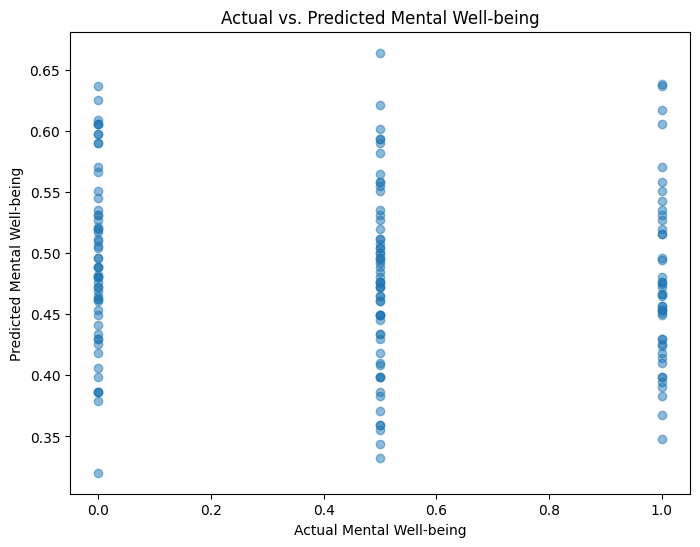

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Load the data
df = pd.read_csv('cap1.csv')

# Convert categorical variables to numerical for analysis
df = df.replace({'Yes': 1, 'No': 0, 'Maybe': 0.5})

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Age', 'Gender', 'Occupation', 'Days_Indoors', 'Mood_Swings'])

# Define features and target variable
X = df_encoded.drop(columns=['Mental_Health_History'])
y = df_encoded['Mental_Health_History']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Mental Well-being")
plt.ylabel("Predicted Mental Well-being")
plt.title("Actual vs. Predicted Mental Well-being")
plt.show()
